# Анализ физических лиц: построение мультимодальной тематической модели

Описание модели:
- 400к клиентов 
- данные в виде транзакций
- НЕ темпоральная модель (время не учитывается)
- построена по абсолютным суммам транзакций
- построена по номерам карт
- 30 тем
- с модальностями

In [1]:
import sys
sys.path.append('/home/roseaysina/bigartm/python')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import json
import artm
import re
import pickle

In [3]:
import sys
sys.path.insert(0, '../code/')

In [4]:
import tm_experiments as tme
import tm_metrics as tmm
import segmentation as seg

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Загрузка данных

In [6]:
MCC_codes = pd.read_excel('/data_ssd/shared_files/pfm/data/справочник mcc.xlsx', )
mcc = MCC_codes[['MCC_CODE', 'EDITED_DESC', 'Group Anna']]
mcc['codes'] = MCC_codes['Group Anna'].str.lower().astype('category').cat.codes
mcc['cat_name'] = [MCC_codes['Group Anna'].str.lower().astype('category').cat.categories[i] for i in mcc['codes']]
mcc = mcc[mcc.codes > 0]
mcc = mcc[~mcc.MCC_CODE.duplicated(keep='last')]

/home/phillnik/miniconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/phillnik/miniconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
mcc2descr = {str(row['codes']): row['cat_name']
             for index, row in mcc.iterrows()}

## Для чего строится модель: клиентов или карт

In [8]:
user_field = 'client_id_way4'
#user_field = 'cardnumber'

# Загрузка батчей и словаря:

In [9]:
batch_vectorizer = artm.BatchVectorizer(target_folder='../data/topic_model_files', 
                                        data_path='../data/data_400k_vw_meta_clients_cat.txt',
                                        data_format='vowpal_wabbit')

In [10]:
dictionary = batch_vectorizer.dictionary
num_topics = 30  # количество тем
num_back = 1  # количество тем общей лексики

In [11]:
thresholds = [0, 0.3, 0.5, 0.7, 0.9]

In [12]:
num_iter = 15

# К уже хорошо обученной тематической модели добавляются модальности: возрастная категория и пол

# 0. Модель PLSA

In [125]:
model0 = artm.ARTM(num_topics=num_topics, class_ids={'@default': 1.0, '@age': 0.01, '@gender': 0.01,  '@msd':0.01, '@edu':0.01},
                   dictionary=dictionary, cache_theta=True, reuse_theta=True,
                   theta_columns_naming='title', theta_name = 'theta')
model0.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary, class_ids=['@default']))
model0.scores.add(artm.PerplexityScore(name='PerplexityScore_age', dictionary=dictionary, class_ids=['@age']))
model0.scores.add(artm.PerplexityScore(name='PerplexityScore_old', dictionary=dictionary, class_ids=['@gender']))
model0.scores.add(artm.PerplexityScore(name='PerplexityScore_msd', dictionary=dictionary, class_ids=[ '@msd']))
model0.scores.add(artm.PerplexityScore(name='PerplexityScore_edu', dictionary=dictionary, class_ids=['@edu']))
model0.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore',
                                        topic_names=model0.topic_names[:-num_back], class_id='@default'))

model0.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore',
                                          topic_names=model0.topic_names[:-num_back]))

model0.scores.add(artm.TopTokensScore(name='TopTokensScore', dictionary=dictionary, class_id='@default'))

In [126]:
model0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_iter)

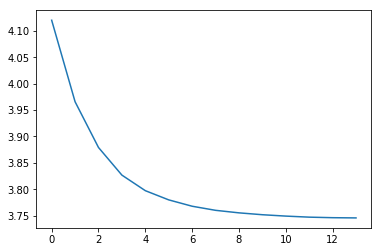

In [127]:
plt.plot(model0.score_tracker['PerplexityScore_edu'].value[1:])

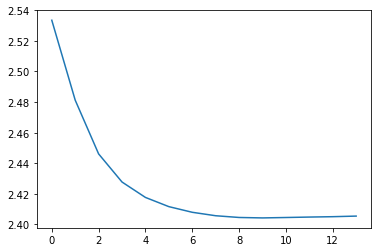

In [128]:
plt.plot(model0.score_tracker['PerplexityScore_msd'].value[1:])

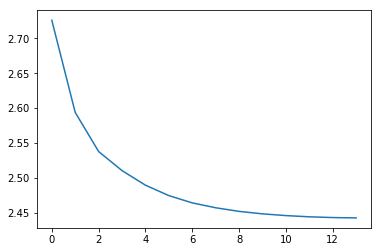

In [129]:
plt.plot(model0.score_tracker['PerplexityScore_age'].value[1:])

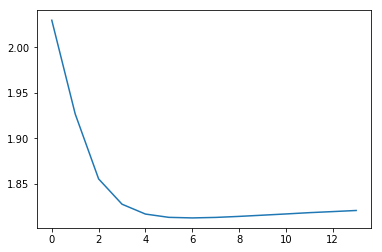

In [130]:
plt.plot(model0.score_tracker['PerplexityScore_old'].value[1:])

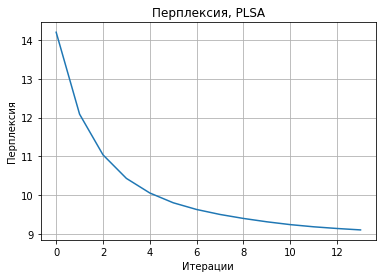

In [131]:
tmm.plot_perplexity(model0, 'PLSA')

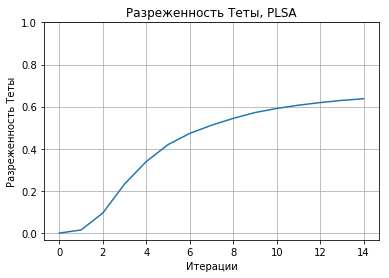

In [132]:
tmm.plot_theta_sparsity(model0, 'PLSA')

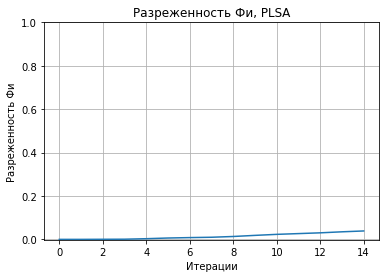

In [133]:
tmm.plot_phi_sparsity(model0, 'PLSA')

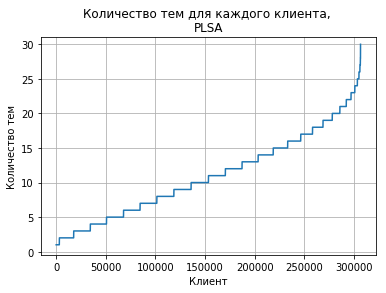

In [134]:
tmm.plot_people_score(model0, 0, '\nPLSA')

[13 23  7 17 16 19 28  8 10  5 24  6  2  1 12 26 14 11 29 18 25 22 27 15
  0  3  9 20  4 21]


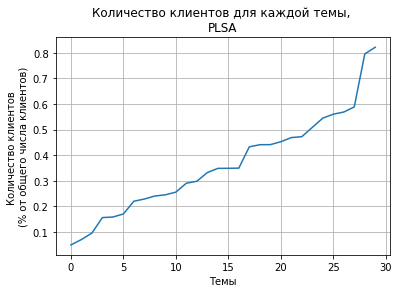

In [135]:
tmm.plot_topics_score(model0, 0, '\nPLSA')

In [136]:
tmm.print_top_tokens(model0, mcc2descr, thresholds, 
                     'PLSA', 
                     '../data/VCR/plsa_grp_mlt.txt',
                     modalities=['@msd', '@edu', '@age', '@gender'])

In [137]:
model0.get_theta().shape

(30, 306507)

In [31]:
model0.dump_artm_model('../data/VCR/plsa_grp_mlt')

OSError: Folder ../data/VCR/plsa_grp_mlt already exists

# 1. Разреживание Фи для предметных тем

In [141]:
best_tau = -10000
model1 = model0.clone()
model1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer',
                                                        class_ids=['@default'],
                                                        tau=best_tau,
                                                        topic_names=model1.topic_names[:-num_back]))
model1.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

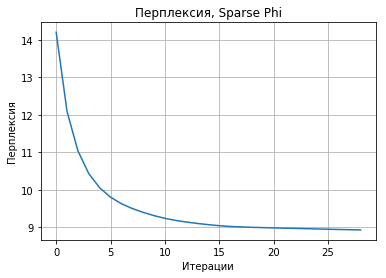

In [142]:
tmm.plot_perplexity(model1, 'Sparse Phi')

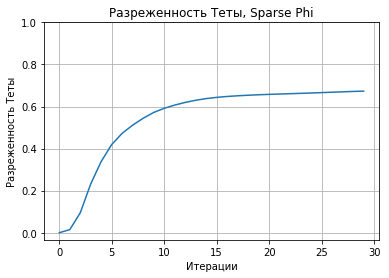

In [143]:
tmm.plot_theta_sparsity(model1, 'Sparse Phi')

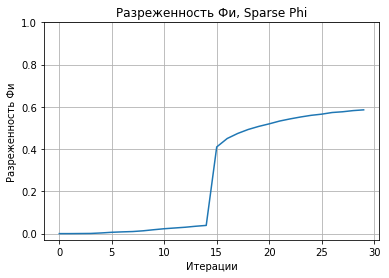

In [144]:
tmm.plot_phi_sparsity(model1, 'Sparse Phi')

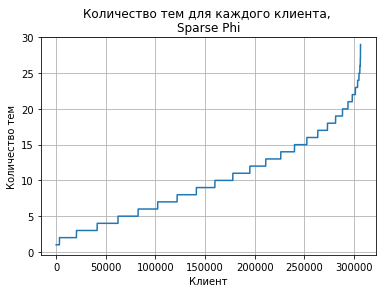

In [145]:
tmm.plot_people_score(model1, 0, '\nSparse Phi')

[13 23  7 28 16 17 19 10  8  5 24  1  2  6  9 26 12 14 29 11  3 18 20 22
 25 15  0 27  4 21]


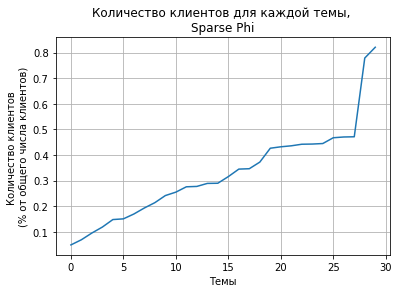

In [146]:
tmm.plot_topics_score(model1, 0, '\nSparse Phi')

In [147]:
tmm.print_top_tokens(model1, mcc2descr, thresholds, 'Sparse Phi', 
                     '../data/topic_model_files/spars_phi.txt', 
                     modalities=['@msd', '@edu', '@age', '@gender'])

# 2. Сглаживание Фи для тем общей лексики

Подбор коэффициентов:

In [148]:
best_tau = 100
model2 = model1.clone()
model2.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer',
                                                        class_ids=['@default'],
                                                        tau=best_tau,
                                                        topic_names=model2.topic_names[-num_back:]))
model2.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

In [149]:
tmm.print_top_tokens(model2, mcc2descr, thresholds, 
                     'Smooth Phi', 
                     '../data/topic_model_files/smooth_phi.txt', 
                     modalities=['@msd', '@edu', '@age', '@gender'])

In [150]:
best_tau = -500
model3 = model2.clone()
model3.regularizers.add(artm.DecorrelatorPhiRegularizer(name='Dec',
                                                        class_ids=['@default'],
                                                        tau=best_tau))
model3.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

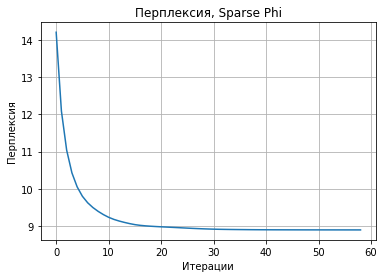

In [151]:
tmm.plot_perplexity(model3, 'Sparse Phi')

# 3. Разреживание Теты для предметных тем

In [152]:
best_tau = -200.
model4 = model3.clone()
model4.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                        tau=best_tau,
                                                        topic_names=model3.topic_names[:-num_back]))
model4.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

In [153]:
model4.score_tracker['PerplexityScore'].value

[68.50348663330078,
 14.20322036743164,
 12.087888717651367,
 11.03795337677002,
 10.429681777954102,
 10.052783966064453,
 9.800558090209961,
 9.626951217651367,
 9.498446464538574,
 9.395705223083496,
 9.309118270874023,
 9.23642635345459,
 9.180066108703613,
 9.136295318603516,
 9.099699020385742,
 9.067094802856445,
 9.03980541229248,
 9.020482063293457,
 9.007080078125,
 8.99699878692627,
 8.988652229309082,
 8.981287002563477,
 8.974397659301758,
 8.967608451843262,
 8.96068286895752,
 8.953380584716797,
 8.946084976196289,
 8.93923568725586,
 8.933003425598145,
 8.927271842956543,
 8.922202110290527,
 8.917821884155273,
 8.914595603942871,
 8.912134170532227,
 8.91012954711914,
 8.90841007232666,
 8.906933784484863,
 8.905627250671387,
 8.904341697692871,
 8.903229713439941,
 8.9024076461792,
 8.901762962341309,
 8.901211738586426,
 8.900766372680664,
 8.90039348602295,
 8.900074005126953,
 8.899785041809082,
 8.89953327178955,
 8.899298667907715,
 8.899089813232422,
 8.89890289

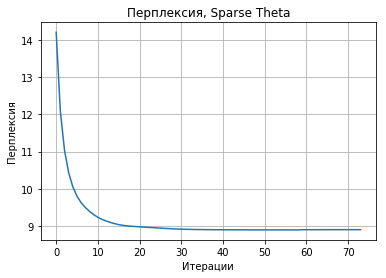

In [154]:
tmm.plot_perplexity(model4, 'Sparse Theta')

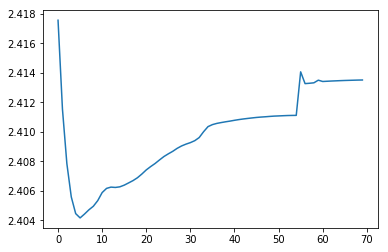

In [124]:
plt.plot(model4.score_tracker['PerplexityScore_msd'].value[5:])

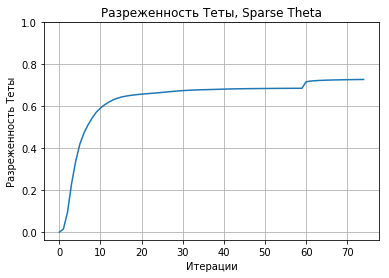

In [79]:
tmm.plot_theta_sparsity(model4, 'Sparse Theta')

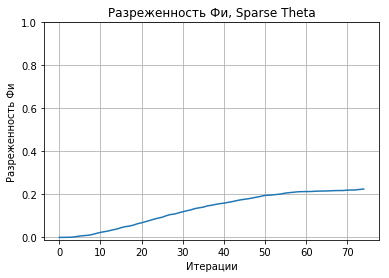

In [80]:
tmm.plot_phi_sparsity(model4, 'Sparse Theta')

[13 23  7 28 16 17  9 10 19  8 24  1  5  2  0  6 26  3 14 12 20 11 29 15
 27 18 22 25  4 21]


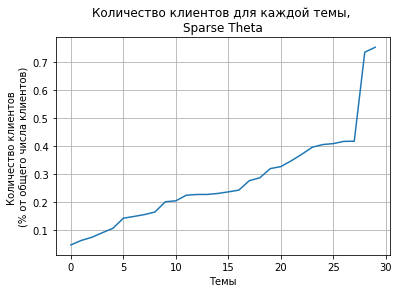

In [81]:
tmm.plot_topics_score(model4, 0, '\nSparse Theta')

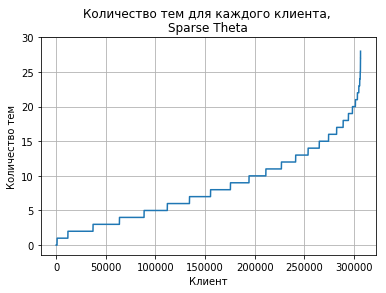

In [82]:
tmm.plot_people_score(model4, 0, '\nSparse Theta')

In [83]:
tmm.print_top_tokens(model4, mcc2descr, thresholds, 
                     'Spase Theta', 
                     '../data/VCR/reg_plsa_grp_mlt.txt',
                     modalities=['@msd', '@edu', '@age', '@gender'])

In [84]:
def people_score(model, threshold=0):
    return np.sort(np.sum(model.get_theta().values > threshold, axis=0))

/home/phillnik/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([1.16998027e-02, 6.23267052e-02, 7.47291253e-02, 7.74102572e-02,
        7.52604578e-02, 7.51590852e-02, 7.51660764e-02, 7.41558454e-02,
        7.11775867e-02, 6.82797270e-02, 6.39346852e-02, 5.88380876e-02,
        5.27242678e-02, 4.77115647e-02, 0.00000000e+00, 4.17830122e-02,
        3.52252500e-02, 2.88247903e-02, 2.33681449e-02, 1.81037581e-02,
        1.32972959e-02, 8.98371466e-03, 5.87262281e-03, 3.68786730e-03,
        2.07639164e-03, 9.92752904e-04, 4.22968667e-04, 1.67789223e-04,
        4.19473058e-05, 6.99121763e-06]),
 array([ 1.        ,  1.93333333,  2.86666667,  3.8       ,  4.73333333,
         5.66666667,  6.6       ,  7.53333333,  8.46666667,  9.4       ,
        10.33333333, 11.26666667, 12.2       , 13.13333333, 14.06666667,
        15.        , 15.93333333, 16.86666667, 17.8       , 18.73333333,
        19.66666667, 20.6       , 21.53333333, 22.46666667, 23.4       ,
        24.33333333, 25.26666667, 26.2       , 27.13333333, 28.06666667,
        29.     

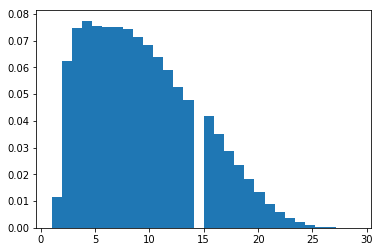

In [85]:
plt.hist(people_score(model0, 1e-5), bins=30, normed=True)

In [86]:
def plot_hist_people_score(model, threshold, title=None, path=None):
    score = people_score(model, threshold)
    plt.hist(score, bins=30, normed=True, color='steelblue')

    plt.axvline(score.mean(), linestyle='dashed', color='darkblue', linewidth=2, label='Mean')
    qs = [25, 50, 75]
    colors = ['r', 'limegreen', 'darkorange']
    for q, color in zip(qs, colors):
        percentile = np.percentile(score, q=q)
        plt.axvline(percentile,
                    linewidth=2,
                    label='{0}-percentile = {1}'.format(q / 100, int(percentile)),
                    color=color)
    if title is not None:
        plt.title('Распределение количества тем у клиентов, {0}'.format(title))
    else:
        plt.title('Распределение количества тем у клиентов')

    plt.xlabel('Количество тем')
    plt.ylabel('Количество клиентов \n(% от общего числа)')
    plt.xticks(np.arange(len(model.topic_names) + 1, step=5))
    plt.grid()
    plt.legend()

    if path:
        plt.savefig(path,
                    additional_artists=[],
                    bbox_inches="tight")
    plt.show()

/home/phillnik/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


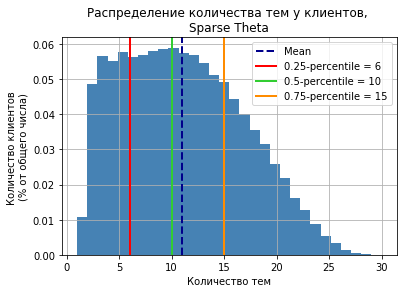

In [87]:
tmm.plot_hist_people_score(model0, 0, '\nSparse Theta')

/home/phillnik/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


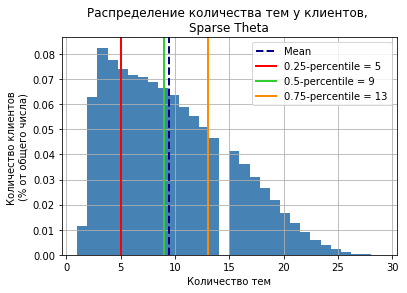

In [88]:
tmm.plot_hist_people_score(model3, 0, '\nSparse Theta')

In [90]:
model4.dump_artm_model('../data/VCR/reg_plsa_grp_mlt')

OSError: Folder ../data/VCR/reg_plsa_grp_mlt already exists

In [ ]:
theta = model3.get_theta().T
dct = dict(zip(theta.index, range(theta.shape[0])))
idxs = theta[theta.topic_1 < 0.5].index

In [40]:
with open('../data/data_400k_vw_meta_clients_cat.txt', 'r') as f:
    lines = f.readlines()
idxs_origin = [i.split(' ')[0] for i in lines]
theta = theta.loc[idxs_origin]

In [41]:
new_lines = []
for i in idxs:
    new_lines.append(lines[dct[i]])
    

In [42]:
with open('../data/data_400k_vw_meta_clients_cat_3.txt', 'w') as f:
    lines = f.writelines(new_lines)

In [43]:
path_to_data = '/data_ssd/shared_files/pfm/data/'
df = pd.read_pickle(path_to_data + 'nwd_categories_clients.pkl')
df = df[~df.index.isin([17, 20])]
#df.to_pickle(path_to_data + 'nwd_categories_clients_1.pkl')

In [41]:
df.loc[16]

client_id_way4
7391205           0.00
7391316           0.00
7391381           0.00
7391749           0.00
7392073           0.00
7394457           0.00
7394983           0.00
7395244           0.00
7395847           0.00
7395885           0.00
7396091           0.00
7396390           0.00
7396455           0.00
7396841         800.00
7397470           0.00
7397677       15396.00
7399065           0.00
7400057           0.00
7400355           0.00
7400958           0.00
7402792           0.00
7402842           0.00
7403647        2000.00
7404238           0.00
7416446           0.00
7416798           0.00
7417608           0.00
7417896           0.00
7417999           0.00
7418444           0.00
                ...   
4428174110     1861.05
4428906580        0.00
4428921070        0.00
4429564340        0.00
4430367500        0.00
4430565350        0.00
4430849970     1717.00
4430902600        0.00
4430962050        0.00
4431422440        0.00
4431998140        0.00
4432109680      126

## Сохранение модели:

In [42]:
path_save = '../data/model_30top_400k_mlt_cat'
model3.dump_artm_model(path_save)

OSError: Folder ../data/model_30top_400k_mlt_cat already exists

# Сравнение всех моделей

In [ ]:
models = [model0, model1, model2, model3]
labels = ['PLSA', 'Sparse Phi', 'Smooth Phi', 'Sparse Theta']

tmm.plot_people_comparison(models, labels)
tmm.plot_topics_comparison(models, labels)
tmm.plot_perplexity_comparison(models, labels)
tmm.plot_phi_sparsity_comparison(models, labels)
tmm.plot_theta_sparsity_comparison(models, labels)